In [1]:
import re
import os
import sys
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Data helpers

In [2]:
def gen_index(setting_index):
    train_index=[]
    test_index =[]
    if setting_index == 0:
        for i in range(1,9):
            if i <= 4:
                train_index.append(('lab',i))
            else:
                test_index.append(('lab',i))
        for i in range(1,7):
            if i <= 3:
                train_index.append(('office',i))
            else:
                test_index.append(('office',i))
        for i in range(1,7):
            if i <= 3:
                train_index.append(('house',i))
            else:
                test_index.append(('house',i))
    elif setting_index == 1:
        for i in range(1,9):
            train_index.append(('lab',i))
        for i in range(1,7):
            train_index.append(('office',i))
        for i in range(1,7):
            test_index.append(('house',i))
    else:
        raise ValueError('error setting index')

    return train_index, test_index

def load_image_paths(image_folder_path='dataset/frames/',
                     data_type='train',
                     label_type='obj',
                     image_type = 'left'):
    
    # Re-format to pre-defined folder names.
    if image_type == 'left':
        image_type = 'Lhand'
    elif image_type == 'right':
        image_type = 'Rhand'
    else:
        image_type = 'head'
    
    image_paths = []
    
    # Hard-coded due to the given dataset splitted by the original author.
    if data_type == 'train':
        index, _ = gen_index(setting_index=0)
    elif data_type == 'test':
        _, index = gen_index(setting_index=0)
        
        # The given `split_id` of image and label in test data are not consistant.
        # e.g. "dataset/frames/test/lab/1" <=> "dataset/labels/lab/xxx_xxx*5*.npy"
        # Based on this example, the generated test `split_id` will started from *5*,
        # we need to let `split_id` start from *1*.
        split_num = {'lab': 0, 'office': 0, 'house': 0}
        
        for tup in index:
            scene_type = tup[0]
            split_num[scene_type] += 1
            
        for i, tup in enumerate(index):
            scene_type, split_id = tup
            tmp_split_id = split_id % split_num[scene_type] 
            split_id = tmp_split_id if tmp_split_id > 0 else split_num[scene_type]
            index[i] = (scene_type, split_id) 

    # Load image paths.
    for tup in index:
        scene_type, split_id = tup
        target_folder_path = os.path.join(image_folder_path, data_type, scene_type, str(split_id), image_type)
        file_names = os.listdir(target_folder_path)
        file_names = sorted(file_names, key=lambda x: int(re.sub('\D', '', x)))
        image_paths.extend([os.path.join(target_folder_path, file_name) for file_name in file_names])
        
        
    return image_paths
        
def load_labels(label_folder_path='dataset/labels',
                data_type='train',
                label_type='obj',
                hand_type = 'left'):
    """ Note that we do not have labels for head images. """
    
    labels = []
    
    # Hard-coded due to the given dataset splitted by the original author.
    if data_type == 'train':
        index, _ = gen_index(setting_index=0)
    elif data_type == 'test':
        _, index = gen_index(setting_index=0)

    # Load labels
    for tup in index:
        scene_type, split_id = tup
        label_npy_path = os.path.join(label_folder_path, scene_type, 
                                      '{}_{}{}.npy'.format(label_type, hand_type, split_id))
        
        label_npy = np.load(label_npy_path)
        labels.append(label_npy)

    labels = np.concatenate(labels)
    
    return labels

def load_examples(image_folder_path='dataset/frames/',
                  label_folder_path='dataset/labels',
                  data_type='train',
                  label_type='obj',
                  hand_type='left',
                  with_head=False):
    
    hand_image_paths = load_image_paths(image_folder_path=image_folder_path, 
                                        data_type=data_type, 
                                        label_type=label_type,
                                        image_type=hand_type)
    
    if with_head:
        head_image_paths = load_image_paths(image_folder_path=image_folder_path, 
                                        data_type=data_type, 
                                        label_type=label_type,
                                        image_type='head')
    
    labels = load_labels(label_folder_path=label_folder_path,
                         data_type=data_type,
                         label_type=label_type,
                         hand_type=hand_type)
    
    if with_head:
        return head_image_paths, hand_image_paths, labels
    else:
        return hand_image_paths, labels

### Load training, validation and testing data

In [36]:
IMAGE_FOLDER_PATH = 'dataset/frames/'
LABEL_FOLDER_PATH = 'dataset/labels/'

image_paths, labels = load_examples(image_folder_path=IMAGE_FOLDER_PATH,
                                    label_folder_path=LABEL_FOLDER_PATH,
                                    data_type='train', label_type='obj')

train_image_paths, val_image_paths, train_labels, val_labels = \
    train_test_split(image_paths, labels, test_size=0.2, random_state=42)

test_image_paths, test_labels = load_examples(image_folder_path=IMAGE_FOLDER_PATH,
                                              label_folder_path=LABEL_FOLDER_PATH,
                                              data_type='test', label_type='obj')

num_classes = 24 # label type: 'obj'

In [24]:
image_paths[:10]

['dataset/frames/train/lab/1/Lhand/Image1.png',
 'dataset/frames/train/lab/1/Lhand/Image2.png',
 'dataset/frames/train/lab/1/Lhand/Image3.png',
 'dataset/frames/train/lab/1/Lhand/Image4.png',
 'dataset/frames/train/lab/1/Lhand/Image5.png',
 'dataset/frames/train/lab/1/Lhand/Image6.png',
 'dataset/frames/train/lab/1/Lhand/Image7.png',
 'dataset/frames/train/lab/1/Lhand/Image8.png',
 'dataset/frames/train/lab/1/Lhand/Image9.png',
 'dataset/frames/train/lab/1/Lhand/Image10.png']

In [37]:
print('[Train] data/label: {}/{}'.format(len(train_image_paths), len(train_image_paths)))
print('[Validation] data/label: {}/{}'.format(len(val_image_paths), len(val_labels)))
print('[Test] data/label: {}/{}'.format(len(test_image_paths), len(test_labels)))
print('Class number: {}'.format(num_classes))

[Train] data/label: 5996/5996
[Validation] data/label: 1500/1500
[Test] data/label: 6388/6388
Class number: 24


### Let's plot label distributions

In [5]:
class_label_str = {
    
    'FA':{  'free':0, 
            'active':1},

    'obj':{ 'free':0,
            'computer':1,
            'cellphone':2,
            'coin':3,
            'ruler':4,
            'thermos-bottle':5,
            'whiteboard-pen':6,
            'whiteboard-eraser':7,
            'pen':8,
            'cup':9,
            'remote-control-TV':10,
            'remote-control-AC':11,
            'switch':12,
            'windows':13,
            'fridge':14,
            'cupboard':15,
            'water-tap':16,
            'toy':17,
            'kettle':18,
            'bottle':19,
            'cookie':20,
            'book':21,
            'magnet':22,
            'lamp-switch':23},

    'ges':{ 'free':0,
            'press':1,
            'large-diameter':2,
            'lateral-tripod':3,
            'parallel-extension':4,
            'thumb-2-finger':5,
            'thumb-4-finger':6,
            'thumb-index-finger':7,
            'precision-disk':8,
            'lateral-pinch':9,
            'tripod':10,
            'medium-wrap':11,
            'light-tool':12}
}

# inverse dictionary for each mode
for mode in class_label_str.keys():
    class_label_str[mode] = {v:k for k,v in class_label_str[mode].items()}

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

### Training label distrubution

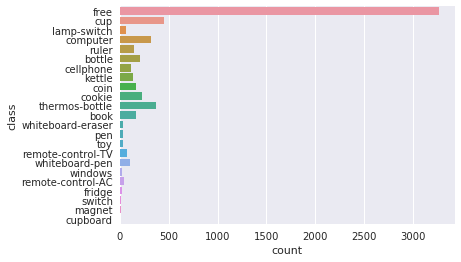

In [7]:
df_train_labels = pd.DataFrame(data=[class_label_str['obj'][int(label)] for label in train_labels], columns=['class'])
sns.countplot(y="class", data=df_train_labels)

### Validation label distribution

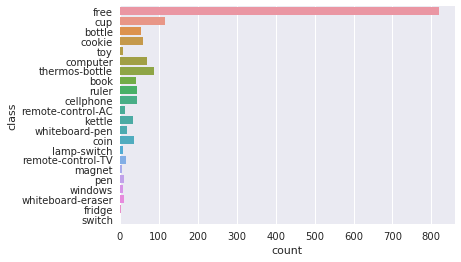

In [8]:
df_val_labels = pd.DataFrame(data=[class_label_str['obj'][int(label)] for label in val_labels], columns=['class'])
sns.countplot(y="class", data=df_val_labels)

### Testing label distribution

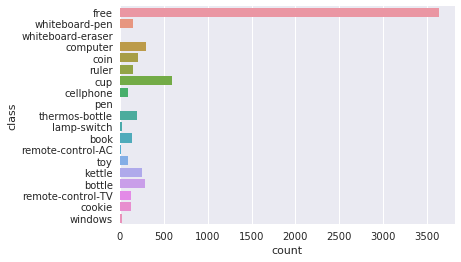

In [9]:
df_test_labels = pd.DataFrame(data=[class_label_str['obj'][int(label)] for label in test_labels], columns=['class'])
sns.countplot(y="class", data=df_test_labels)

### Use Tensorflow to build computational graph

In [10]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets

In [11]:
import vgg_preprocessing

In [17]:
pretrained_vgg_model_path = 'model/vgg_16.ckpt'
model_path = 'model/baseline_finetuned_vgg_16.ckpt'

batch_size = 32
num_workers = 20
num_epochs1 = 10
num_epochs2 = 10
learning_rate1 = 1e-3
learning_rate2 = 1e-5
dropout_keep_prob = 0.5
weight_decay = 5e-4

VGG_MEAN = [123.68, 116.78, 103.94]

In [27]:
%%time

# --------------------------------------------------------------------------
# In TensorFlow, you first want to define the computation graph with all the
# necessary operations: loss, training op, accuracy...
# Any tensor created in the `graph.as_default()` scope will be part of `graph`
graph = tf.Graph()
with graph.as_default():
    # Standard preprocessing for VGG on ImageNet taken from here:
    # https://github.com/tensorflow/models/blob/master/research/slim/preprocessing/vgg_preprocessing.py
    # Also see the VGG paper for more details: https://arxiv.org/pdf/1409.1556.pdf

    # Preprocessing (for both training and validation):
    # (1) Decode the image from jpg format
    # (2) Resize the image so its smaller side is 256 pixels long
    def _parse_function(filename, label):
            image_string = tf.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)          # (1)
            image = tf.cast(image_decoded, tf.float32)

            smallest_side = 256.0
            height, width = tf.shape(image)[0], tf.shape(image)[1]
            height = tf.to_float(height)
            width = tf.to_float(width)

            scale = tf.cond(tf.greater(height, width),
                            lambda: smallest_side / width,
                            lambda: smallest_side / height)
            new_height = tf.to_int32(height * scale)
            new_width = tf.to_int32(width * scale)

            resized_image = tf.image.resize_images(image, [new_height, new_width])  # (2)
                
            return resized_image, label
        
    # Preprocessing (for training)
    # (3) Take a random 224x224 crop to the scaled image
    # (4) Horizontally flip the image with probability 1/2
    # (5) Substract the per color mean `VGG_MEAN`
    # Note: we don't normalize the data here, as VGG was trained without normalization
    def training_preprocess(image, label):
        crop_image = tf.random_crop(image, [224, 224, 3])                       # (3)
        flip_image = tf.image.random_flip_left_right(crop_image)                # (4)

        means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
        centered_image = flip_image - means                                     # (5)

        return centered_image, label
    
    # Preprocessing (for validation)
    # (3) Take a central 224x224 crop to the scaled image
    # (4) Substract the per color mean `VGG_MEAN`
    # Note: we don't normalize the data here, as VGG was trained without normalization
    def val_preprocess(image, label):
        crop_image = tf.image.resize_image_with_crop_or_pad(image, 224, 224)    # (3)

        means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
        centered_image = crop_image - means                                     # (4)

        return centered_image, label
    
    # ----------------------------------------------------------------------
    # DATASET CREATION using tf.contrib.data.Dataset
    # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data

    # The tf.contrib.data.Dataset framework uses queues in the background to feed in
    # data to the model.
    # We initialize the dataset with a list of filenames and labels, and then apply
    # the preprocessing functions described above.
    # Behind the scenes, queues will load the filenames, preprocess them with multiple
    # threads and apply the preprocessing in parallel, and then batch the data

    # Training dataset
    _train_image_paths = tf.constant(train_image_paths)
    _train_labels = tf.constant(train_labels.astype(np.int32))
    train_dataset = tf.contrib.data.Dataset.from_tensor_slices((_train_image_paths, _train_labels))
    train_dataset = train_dataset.map(_parse_function, num_threads=num_workers, output_buffer_size=batch_size)
    train_dataset = train_dataset.map(training_preprocess, num_threads=num_workers, output_buffer_size=batch_size)
    train_dataset = train_dataset.shuffle(buffer_size=10000)  # don't forget to shuffle
    batched_train_dataset = train_dataset.batch(batch_size)
    
    # Validation dataset
    _val_image_paths = tf.constant(val_image_paths)
    _val_labels = tf.constant(val_labels.astype(np.int32))
    val_dataset = tf.contrib.data.Dataset.from_tensor_slices((_val_image_paths, _val_labels))
    val_dataset = val_dataset.map(_parse_function, num_threads=num_workers, output_buffer_size=batch_size)
    val_dataset = val_dataset.map(val_preprocess, num_threads=num_workers, output_buffer_size=batch_size)
    val_dataset = val_dataset.shuffle(buffer_size=10000)  # don't forget to shuffle
    batched_val_dataset = val_dataset.batch(batch_size)
        
    # Now we define an iterator that can operator on either dataset.
    # The iterator can be reinitialized by calling:
    #     - sess.run(train_init_op) for 1 epoch on the training set
    #     - sess.run(val_init_op)   for 1 epoch on the valiation set
    # Once this is done, we don't need to feed any value for images and labels
    # as they are automatically pulled out from the iterator queues.

    # A reinitializable iterator is defined by its structure. We could use the
    # `output_types` and `output_shapes` properties of either `train_dataset`
    # or `validation_dataset` here, because they are compatible.
    iterator = tf.contrib.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                       batched_train_dataset.output_shapes)
    
    # A batch of data to feed into the networks.
    images, labels = iterator.get_next()
    
    train_init_op = iterator.make_initializer(batched_train_dataset)
    val_init_op = iterator.make_initializer(batched_val_dataset)

    # Indicates whether we are in training or in test mode
    # Since VGG16 has applied `dropout`, we need to disable it when testing.
    is_training = tf.placeholder(tf.bool)
    
    # ---------------------------------------------------------------------
    # Now that we have set up the data, it's time to set up the model.
    # For this example, we'll use VGG-16 pretrained on ImageNet. We will remove the
    # last fully connected layer (fc8) and replace it with our own, with an
    # output size `num_classes`
    # We will first train the last layer for a few epochs.
    # Then we will train the entire model on our dataset for a few epochs.

    # Get the pretrained model, specifying the num_classes argument to create a new
    # fully connected replacing the last one, called "vgg_16/fc8"
    # Each model has a different architecture, so "vgg_16/fc8" will change in another model.
    # Here, logits gives us directly the predicted scores we wanted from the images.
    # We pass a scope to initialize "vgg_16/fc8" weights with he_initializer
    vgg = tf.contrib.slim.nets.vgg
    with slim.arg_scope(vgg.vgg_arg_scope(weight_decay=weight_decay)):
        logits, _ = vgg.vgg_16(images, num_classes=num_classes, is_training=is_training,
                               dropout_keep_prob=dropout_keep_prob)
        
    # Restore only the layers up to fc7 (included)
    # Calling function `init_fn(sess)` will load all the pretrained weights.
    variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['vgg_16/fc8'])
    init_fn = tf.contrib.framework.assign_from_checkpoint_fn(pretrained_vgg_model_path, variables_to_restore)

    # Initialization operation from scratch for the new "fc8" layers
    # `get_variables` will only return the variables whose name starts with the given pattern
    fc8_variables = tf.contrib.framework.get_variables('vgg_16/fc8')
    fc8_init = tf.variables_initializer(fc8_variables)
    
    # ---------------------------------------------------------------------
    # Using tf.losses, any loss is added to the tf.GraphKeys.LOSSES collection
    # We can then call the total loss easily
    tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    loss = tf.losses.get_total_loss()
    
    # First we want to train only the reinitialized last layer fc8 for a few epochs.
    # We run minimize the loss only with respect to the fc8 variables (weight and bias).
    fc8_optimizer = tf.train.GradientDescentOptimizer(learning_rate1)
    fc8_train_op = fc8_optimizer.minimize(loss, var_list=fc8_variables)
    
    # Then we want to finetune the entire model for a few epochs.
    # We run minimize the loss only with respect to all the variables.
    full_optimizer = tf.train.GradientDescentOptimizer(learning_rate2)
    full_train_op = full_optimizer.minimize(loss)

    # Evaluation metrics
    prediction = tf.to_int32(tf.argmax(logits, 1))
    correct_prediction = tf.equal(prediction, labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    
    # 'Saver' op to save and restore all the variables
    saver = tf.train.Saver()

CPU times: user 1.83 s, sys: 40.7 ms, total: 1.87 s
Wall time: 1.83 s


### Training

In [19]:
def evaluate(sess, loss, correct_prediction, data_init_op):
    """
        Evaluation in training loop.
        Check the performance of the model on either train, val or test (depending on `data_init_op`)
        Note: The arguments are tensorflow operators defined in the graph.
    """
    
    # Initialize the correct dataset.
    sess.run(data_init_op)

    data_loss = 0
    num_correct = 0
    num_samples = 0
    
    # Evaluate on every batch.
    while True:
        try:
            # Disable `is_training` since we have `dropout` in VGG net.
            _labels, _loss, _prediction, _correct_prediction = sess.run([labels, loss, prediction, correct_prediction], feed_dict={is_training: False})

            data_loss += _loss
            num_correct += _correct_prediction.sum() # e.g: [True, False, True].sum() = 2
            num_samples += _correct_prediction.shape[0] # Batch size
            
        except tf.errors.OutOfRangeError:
            break

    data_loss = data_loss / num_samples
    acc = num_correct / num_samples

    return data_loss, acc

In [30]:
# --------------------------------------------------------------------------
# Now that we have built the graph and finalized it, we define the session.
# The session is the interface to *run* the computational graph.
# We can call our training operations with `sess.run(train_op)` for instance
sess = tf.Session(graph=graph)

In [21]:
init_fn(sess) # load the pretrained weights
sess.run(fc8_init)  # initialize the new fc8 layer

INFO:tensorflow:Restoring parameters from model/vgg_16.ckpt


In [22]:
max_acc = 0.0

# Update only the last layer for a few epochs.
for epoch in tqdm(range(num_epochs1)):
    # Run an epoch over the training data.
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs1))
    # Here we initialize the iterator with the training set.
    # This means that we can go through an entire epoch until the iterator becomes empty.
    sess.run(train_init_op)
    while True:
        try:
            _ = sess.run(fc8_train_op, feed_dict={is_training: True})
        except tf.errors.OutOfRangeError:
            break

    # Check performance every epoch
    train_loss, train_acc = evaluate(sess, loss, correct_prediction, train_init_op)
    val_loss, val_acc = evaluate(sess, loss, correct_prediction, val_init_op)
    print('[Train] loss: {} | accuracy: {}'.format(train_loss, train_acc))
    print('[Validation] loss: {} | accuracy: {}'.format(val_loss, val_acc))
    
    # Save checkpoint
    if val_acc > max_acc:
        max_acc = val_acc
        save_path = saver.save(sess, model_path)
        print("Model updated and saved in file: %s" % save_path)

# Train the entire model for a few more epochs, continuing with the *same* weights.
for epoch in tqdm(range(num_epochs2)):
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs2))
    sess.run(train_init_op)
    while True:
        try:
            _ = sess.run(full_train_op, feed_dict={is_training: True})
        except tf.errors.OutOfRangeError:
            break

    # Check performance every epoch
    train_loss, train_acc = evaluate(sess, loss, correct_prediction, train_init_op)
    val_loss, val_acc = evaluate(sess, loss, correct_prediction, val_init_op)
    print('[Train] loss: {} | accuracy: {}'.format(train_loss, train_acc))
    print('[Validation] loss: {} | accuracy: {}'.format(val_loss, val_acc))
    
    # Save checkpoint
    if val_acc > max_acc:
        max_acc = val_acc
        save_path = saver.save(sess, model_path)
        print("Model updated and saved in file: %s" % save_path)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting epoch 1 / 10
[Train] loss: 0.06444888776186866 | accuracy: 0.5900600400266844
[Validation] loss: 0.062463754494984945 | accuracy: 0.5966666666666667


 10%|█         | 1/10 [03:40<33:01, 220.14s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 2 / 10
[Train] loss: 0.05608610634886479 | accuracy: 0.6544362908605738
[Validation] loss: 0.053876905600229896 | accuracy: 0.68


 20%|██        | 2/10 [06:05<26:20, 197.59s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 3 / 10
[Train] loss: 0.0506329650358807 | accuracy: 0.7056370913942629
[Validation] loss: 0.04895365858078003 | accuracy: 0.7246666666666667


 30%|███       | 3/10 [08:33<21:20, 182.97s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 4 / 10
[Train] loss: 0.04778650348348726 | accuracy: 0.7196464309539693
[Validation] loss: 0.04607608675956726 | accuracy: 0.7446666666666667


 40%|████      | 4/10 [11:02<17:16, 172.73s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 5 / 10
[Train] loss: 0.04640474907551868 | accuracy: 0.7384923282188125
[Validation] loss: 0.0442477433681488 | accuracy: 0.7586666666666667


 50%|█████     | 5/10 [13:32<13:48, 165.68s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 6 / 10
[Train] loss: 0.044129766926437795 | accuracy: 0.7528352234823216
[Validation] loss: 0.04223733425140381 | accuracy: 0.776


 60%|██████    | 6/10 [16:00<10:42, 160.63s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 7 / 10
[Train] loss: 0.042965724040381986 | accuracy: 0.7688458972648432
[Validation] loss: 0.04150431283315023 | accuracy: 0.7806666666666666


 70%|███████   | 7/10 [18:36<07:57, 159.17s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 8 / 10
[Train] loss: 0.041762586988712484 | accuracy: 0.7806871247498333
[Validation] loss: 0.040805210510889686 | accuracy: 0.7866666666666666


 80%|████████  | 8/10 [21:15<05:18, 159.02s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 9 / 10
[Train] loss: 0.041091706670865445 | accuracy: 0.7871914609739826
[Validation] loss: 0.039414886911710106 | accuracy: 0.7946666666666666


 90%|█████████ | 9/10 [23:54<02:39, 159.08s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 10 / 10


  0%|          | 0/10 [00:00<?, ?it/s]

[Train] loss: 0.04068621486087415 | accuracy: 0.7866911274182788
[Validation] loss: 0.03930794755617777 | accuracy: 0.7906666666666666
Starting epoch 1 / 10
[Train] loss: 0.04029852514707541 | accuracy: 0.7913609072715143
[Validation] loss: 0.038991566816965736 | accuracy: 0.8006666666666666


 10%|█         | 1/10 [03:28<31:14, 208.32s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 2 / 10
[Train] loss: 0.0395048314169934 | accuracy: 0.7985323549032688
[Validation] loss: 0.03884996116161346 | accuracy: 0.8033333333333333


 20%|██        | 2/10 [06:55<27:43, 207.99s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 3 / 10
[Train] loss: 0.04026008613551753 | accuracy: 0.7956971314209473
[Validation] loss: 0.03872858655452728 | accuracy: 0.806


 30%|███       | 3/10 [10:22<24:13, 207.71s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 4 / 10


 40%|████      | 4/10 [13:46<20:39, 206.56s/it]

[Train] loss: 0.03990821172548501 | accuracy: 0.8008672448298866
[Validation] loss: 0.03845855359236399 | accuracy: 0.8053333333333333
Starting epoch 5 / 10
[Train] loss: 0.039806262086120106 | accuracy: 0.7963642428285523
[Validation] loss: 0.038386204957962036 | accuracy: 0.8073333333333333


 50%|█████     | 5/10 [17:13<17:14, 206.83s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 6 / 10
[Train] loss: 0.03986175431856877 | accuracy: 0.8008672448298866
[Validation] loss: 0.03830355453491211 | accuracy: 0.8086666666666666


 60%|██████    | 6/10 [20:41<13:47, 206.95s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 7 / 10
[Train] loss: 0.03946918547352288 | accuracy: 0.8032021347565044
[Validation] loss: 0.03809749968846639 | accuracy: 0.8126666666666666


 70%|███████   | 7/10 [24:08<10:21, 207.12s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt
Starting epoch 8 / 10


 80%|████████  | 8/10 [27:32<06:52, 206.25s/it]

[Train] loss: 0.039463245228499554 | accuracy: 0.8037024683122082
[Validation] loss: 0.0379446158806483 | accuracy: 0.8126666666666666
Starting epoch 9 / 10


 90%|█████████ | 9/10 [30:58<03:26, 206.03s/it]

[Train] loss: 0.039665052757969374 | accuracy: 0.8050366911274183
[Validation] loss: 0.03790290482838948 | accuracy: 0.8126666666666666
Starting epoch 10 / 10
[Train] loss: 0.038977692610745115 | accuracy: 0.8118745830553702
[Validation] loss: 0.03775889460245768 | accuracy: 0.8133333333333334


100%|██████████| 10/10 [34:27<00:00, 206.92s/it]

Model updated and saved in file: model/baseline_finetuned_vgg_16.ckpt


### Testing

In [33]:
sess = tf.Session(graph=graph)

# Restore variables
saver.restore(sess, model_path)

val_image_paths = test_image_paths
val_labels = test_labels

sess.run(val_init_op)

INFO:tensorflow:Restoring parameters from model/baseline_finetuned_vgg_16.ckpt


In [34]:
test_loss, test_acc = evaluate(sess, loss, correct_prediction, val_init_op)
print('[Test] loss: {} | accuracy: {}'.format(test_loss, test_acc))

[Train] loss: 0.056271152322413254 | accuracy: 0.6360363180964308


### Just for debugging

loss: 1.5448894500732422
prediction: [ 0  0  2  0  1  9  0  0  0  0  0  9  0  0  0 18 18  0  9  0 20  0  0  0  0
  0  0  0  0  0  0  0]
labels: [ 0  0  0  0  1  9  0  0  0 19  0  9  0  0  1 18 18 17  9  0 20  1  0  0  0
  5  1  0  0 20  0  0]
correct_prediction: [ True  True False  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True False  True  True
  True False False  True  True False  True  True]
accuracy: 0.75


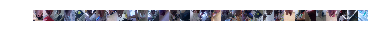

In [32]:
try:
    npy_images, npy_labels, _loss, _prediction, _correct_prediction, _accuracy = \
        sess.run([images, labels, loss, prediction, correct_prediction, accuracy], feed_dict={is_training: False})

    # For plotting
    images_for_plotting = (npy_images[0] - npy_images[0].min()) / (npy_images[0].max() - npy_images[0].min())
    for image in npy_images[1:]:
        normalized_image = (image - image.min()) / (image.max() - image.min())
        images_for_plotting = np.hstack((images_for_plotting, normalized_image))
    plt.axis('off')
    plt.imshow(images_for_plotting)

    print('loss: {}\nprediction: {}\nlabels: {}\ncorrect_prediction: {}\naccuracy: {}'\
          .format(_loss, _prediction, npy_labels, _correct_prediction, _accuracy))

except tf.errors.OutOfRangeError:
    print('Batch Iterator becomes empty. Please re-run again.')
    sess.run(val_init_op)

In [ ]:
sess.close() # Remember to close session after testing.